#Pic2Emoji with OpenAI CLIP !!!

This is a colab for implementing Image to emoji classifier with OpenAI's CLIP. 1063 emoji descriptions are appended with "This photo is" to generate the prompt for CLIP. You can upload any pic to see it in action. Uploaded images are deleted once the session ends.

#Install Pre-Requisites
Installation of torch & other packages. Make sure you are using a GPU runtime. 

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 252kB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=33104570892737edea17517ce2924a04c92ebb235b087d5687ee333c26f4d704
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
import os
import IPython.display
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
from Ipython.display import display

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu101


In [ ]:
#code to get emojiLabels.txt

#Downloading The CLIP Model



In [ ]:
MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

! wget {MODELS["ViT-B/32"]} -O model.pt

--2021-01-30 09:34:12--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M   163MB/s    in 2.1s    

2021-01-30 09:34:14 (163 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [ ]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


#CLIP Preprocessing
Contains utility functions for image transformation and text tokenization

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

In [ ]:
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-01-30 09:34:58--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.01s   

2021-01-30 09:34:58 (98.5 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


#Emoji Data Prep
Download and tokenize emoji descriptions

In [ ]:
lbls = []
unicodes = []
with open("emojiLabels_With_Unicode.txt") as f:
  for line in f:
    ucode, lbl = line.split('::')
    unicodes.append(ucode)
    lbls.append(lbl[:-1])
print(f"unicode for {lbls[1]} is {unicodes[1]}")
print(unicodes[1].replace("\\/", "/").encode().decode("unicode_escape"))

unicode for Smiling Face With Open Mouth is \U0001F603
😃


In [ ]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is a " + desc) for desc in lbls]

In [ ]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

In [ ]:
def findmax5(a):
  idx  = [-1]*5
  val = [-1]*5
  for i in range(len(a)):
    if a[i] > val[0]:
      val[0] = a[i]
      idx[0] = i
    elif val[0] > a[i] > val[1]:
      val[1] = a[i]
      idx[1] = i
    elif val[1] > a[i] > val[2]:
      val[2] = a[i]
      idx[2] = i
    elif val[2] > a[i] > val[3]:
      val[3] = a[i]
      idx[3] = i
    elif val[3] > a[i] > val[4]:
      val[4] = a[i]
      idx[4] = i
  return idx

#Pic2Emoji Uploader
Run the code to upload image. Once uploaded the emojis and description are shown for the image.


Select an image from your system and upload :) (JPEG/PNG)



Saving angrybirds.jpeg to angrybirds.jpeg


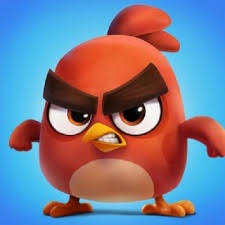

🐥     1. Chick in Frontal View
🐦     2. Bird
🐣     3. Chick in Eggshell
🦉     4. Owl
🐓     5. Rooster


In [ ]:
print("\nSelect an image from your system and upload :) (JPEG/PNG)", end="\n\n")
from google.colab import files
uploaded = files.upload()

key = list(uploaded.keys())[0]
img =Image.open(BytesIO(uploaded[key]))
display(img)

image = preprocess(img.convert('RGB'))
image_input = torch.tensor(np.stack(image)).unsqueeze(0).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
top5 = findmax5(similarity.flatten())

for i in range(5):
  print(unicodes[top5[i]].replace("\\/", "/").encode().decode("unicode_escape"), end = '     ')
  print(f"{i + 1}. {lbls[top5[i]]}")